**Sentiment** **Analysis** - **By** **Prajakta** **Khenat** & **Prashant** **Bangar**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os


# Define the path to the zip file and the extraction directory
zip_file_path = "/content/drive/MyDrive/archive.zip"
extract_dir = "/content"

# Check if the zip file exists
if os.path.exists(zip_file_path):
    try:
        # Create a ZipFile object
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            # Extract all contents to the specified directory
            zip_ref.extractall(extract_dir)
        print(f"Successfully extracted '{zip_file_path}' to '{extract_dir}'")
    except zipfile.BadZipFile:
        print(f"Error: '{zip_file_path}' is not a valid zip file.")
    except Exception as e:
        print(f"An error occurred: {e}")
else:
    print(f"Error: '{zip_file_path}' does not exist.")

Successfully extracted '/content/drive/MyDrive/archive.zip' to '/content'


In [ ]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# List extracted files
print("Files in extraction directory:")
print(os.listdir(extract_dir))

Files in extraction directory:
['.config', 'test.ft.txt.bz2', '.ipynb_checkpoints', 'train.ft.txt.bz2', 'test.ft.txt', 'train.ft.txt', 'drive', 'sample_data']


In [ ]:
import bz2
import shutil

input_path = 'train.ft.txt.bz2'
output_path = 'train.ft.txt'
with bz2.open(input_path, 'rb') as infile:
    with open(output_path, 'wb') as outfile:
        shutil.copyfileobj(infile, outfile)

print(f"Saved decompressed file to {output_path}")

Saved decompressed file to train.ft.txt


In [ ]:
input_path = 'test.ft.txt.bz2'
output_path = 'test.ft.txt'
with bz2.open(input_path, 'rb') as infile:
    with open(output_path, 'wb') as outfile:
        shutil.copyfileobj(infile, outfile)

print(f"Saved decompressed file to {output_path}")

Saved decompressed file to test.ft.txt


In [ ]:
def load_data(file_path, sample_size=None):
    labels = []
    texts = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            label = re.search(r"__label__\d+", line).group()
            text = re.sub(r"__label__\d+\s+", "", line).strip()
            labels.append(label)
            texts.append(text)

    df = pd.DataFrame({'text': texts, 'label': labels})

    # Map to binary sentiment
    df['sentiment'] = df['label'].map(lambda x: 0 if '__label__1' in x else 1)

    if sample_size:
        df = df.sample(n=sample_size, random_state=42)

    return df

# Load training and test data
print("Loading data...")
train_df = load_data('train.ft.txt', sample_size=100000)  # Adjust sample size as needed
test_df = load_data('test.ft.txt', sample_size=20000)

Loading data...


In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove special chars
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.lower().strip()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

print("Preprocessing text...")
train_df['cleaned_text'] = train_df['text'].apply(preprocess_text)
test_df['cleaned_text'] = test_df['text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Preprocessing text...


In [ ]:
X_train = train_df['cleaned_text']
y_train = train_df['sentiment']

X_test = test_df['cleaned_text']
y_test = test_df['sentiment']

Training Logistic Regression model...
Accuracy: 0.88045
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      9966
           1       0.88      0.88      0.88     10034

    accuracy                           0.88     20000
   macro avg       0.88      0.88      0.88     20000
weighted avg       0.88      0.88      0.88     20000



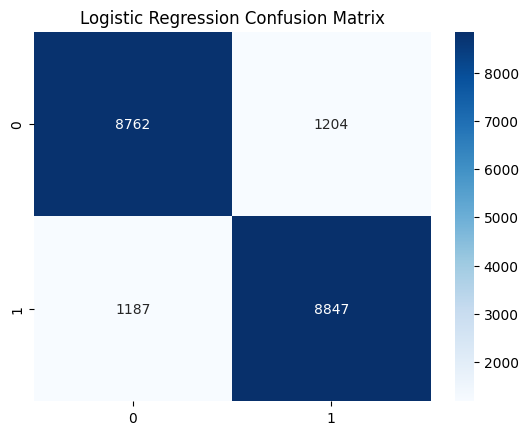

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("Training Logistic Regression model...")
lr_model = LogisticRegression()
lr_model.fit(X_train_tfidf, y_train)

y_pred = lr_model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

In [ ]:
# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

In [ ]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=max_len),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train_pad, y_train, epochs=10, batch_size=128,
                    validation_data=(X_test_pad, y_test), verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 154s 191ms/step - accuracy: 0.4973 - loss: 0.6933 - val_accuracy: 0.5018 - val_loss: 0.6931
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 195s 182ms/step - accuracy: 0.5039 - loss: 0.6931 - val_accuracy: 0.5234 - val_loss: 0.6912
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 208s 190ms/step - accuracy: 0.5280 - loss: 0.6832 - val_accuracy: 0.7809 - val_loss: 0.5014
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 193s 178ms/step - accuracy: 0.8214 - loss: 0.4178 - val_accuracy: 0.8741 - val_loss: 0.2981
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 140s 179ms/step - accuracy: 0.8957 - loss: 0.2537 - val_accuracy: 0.8848 - val_loss: 0.2779
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 145s 183ms/step - accuracy: 0.9085 - loss: 0.2271 - val_accuracy: 0.8831 - val_loss: 0.2797
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 203s 185ms/step - accuracy: 0.9193 - loss: 0.2024 - val_accuracy: 0.8825 - val_loss: 0.2806
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 199s 181ms/step - accuracy: 0.9265 -

LSTM Test Accuracy: 0.8752


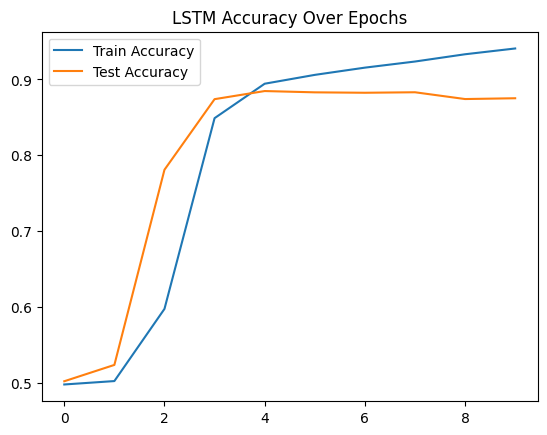

In [ ]:
loss, acc = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"LSTM Test Accuracy: {acc:.4f}")

# Plot Training History
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('LSTM Accuracy Over Epochs')
plt.legend()
plt.show()

In [ ]:
import joblib
from tensorflow.keras.models import save_model

# Save Logistic Regression Model and Vectorizer
joblib.dump(lr_model, 'lr_sentiment_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

# Save LSTM Model
model.save('lstm_sentiment_model.keras')

In [ ]:
def predict_sentiment(text, model_type='lr'):
    cleaned_text = preprocess_text(text)

    if model_type == 'lr':
        vec = vectorizer.transform([cleaned_text])
        prob = lr_model.predict_proba(vec)[0]
        sentiment = "Positive" if lr_model.predict(vec)[0] == 1 else "Negative"
        confidence = max(prob)

    elif model_type == 'lstm':
        seq = tokenizer.texts_to_sequences([cleaned_text])
        pad = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
        prob = model.predict(pad, verbose=0)[0][0]
        sentiment = "Positive" if prob > 0.5 else "Negative"
        confidence = prob if prob > 0.5 else 1 - prob

    return sentiment, confidence